In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from torch import Tensor
from collections import defaultdict
import numpy as np
import time
from representation_model import PENetwork, CompositeClassifierFromRepresentations
ROOT = "../../"
import sys
sys.path.append(ROOT)
from utils.functions import sigmoid, fix_random_seed
from models import Filepath, Emulation

SEED = 42
fix_random_seed(SEED)

dataset_folder = "/data/quo.vadis/evaluation/representations/set_cropped_20/"
dataset_folder = "/data/quo.vadis/evaluation/representations/set_full/"

X_train = np.load(open(dataset_folder + "Xtrain.npy", "rb"))
y_train = np.load(open(dataset_folder + "ytrain.npy", "rb"))
X_val = np.load(open(dataset_folder + "Xval.npy", "rb"))
y_val = np.load(open(dataset_folder + "yval.npy", "rb"))

In [2]:
def fit(models, x_trains, y_train, save=False):
    for model in models:
        print(f"Fitting model: {model}", end=" | ")
        c1 = time.time()
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_meta_model()
        print(f"Took: {time.time() - c1:.2f}s")

def evaluate(models_dict, Xs, y, ax=None, threshold=0.6, print_score=True):
    probs = {}
    for model in models_dict:
        print(f"[!] Evaluating model: {model}...")

        probs[model] = models_dict[model].predict_proba(Xs[model])[:,1]        
        preds = np.where(probs[model] > threshold, 1, 0)
        
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    return probs, ax

def plot_det_curve(models, X_vals, y_val, ax=None, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(X_vals[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_val, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_val, preds, digits=4))

    # model = "No Skill"
    # most_common_label = np.argmax(np.bincount(y_val.astype(int)))
    # probs[model] = np.array([most_common_label for _ in range(len(y_val))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = det_curve(y_val, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('False Negative Rate')
    _ = ax.legend()
    return probs


## Building Xs and modules for analysis of different module combinations

In [3]:
X_trains = {}
X_vals = {}
models = {}

modulelist = [["ember"], ["filepaths"], ["emulation"], 
            ["filepaths", "emulation"], ["ember", "emulation"], 
            ["ember", "filepaths"], ["ember", "filepaths", "emulation"]]

mm = CompositeClassifierFromRepresentations(root=ROOT)

for combination in modulelist:
    name = " & ".join(combination)
    models[name] = CompositeClassifierFromRepresentations(root=ROOT, 
                                                meta_model="XGBClassifier",
                                                load_meta_model = False)
    
    X_trains[name] = mm.get_modular_x(combination, X_train)
    X_vals[name] = mm.get_modular_x(combination, X_val)

In [4]:
fit(models, X_trains, y_train)

Fitting model: ember | Took: 27.28s
Fitting model: filepaths | Took: 6.50s
Fitting model: emulation | Took: 5.83s
Fitting model: filepaths & emulation | Took: 13.95s
Fitting model: ember & emulation | Took: 41.58s
Fitting model: ember & filepaths | Took: 29.10s
Fitting model: ember & filepaths & emulation | Took: 16.41s


[!] Evaluating model: ember...

 ====== ember ======
ROC AUC score: 0.9951072718493895
Classification report:
              precision    recall  f1-score   support

         0.0     0.9524    0.9478    0.9501      4982
         1.0     0.9802    0.9820    0.9811     13120

    accuracy                         0.9726     18102
   macro avg     0.9663    0.9649    0.9656     18102
weighted avg     0.9726    0.9726    0.9726     18102

[!] Evaluating model: filepaths...

 ====== filepaths ======
ROC AUC score: 0.9805182727942545
Classification report:
              precision    recall  f1-score   support

         0.0     0.9481    0.9426    0.9453      4982
         1.0     0.9782    0.9804    0.9793     13120

    accuracy                         0.9700     18102
   macro avg     0.9632    0.9615    0.9623     18102
weighted avg     0.9700    0.9700    0.9700     18102

[!] Evaluating model: emulation...

 ====== emulation ======
ROC AUC score: 0.986576148218954
Classification report:
 

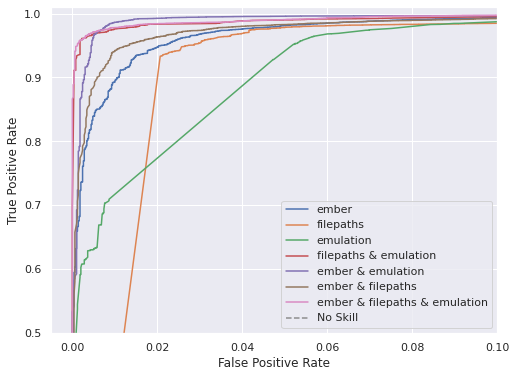

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
probs_val, ax = evaluate(models, X_vals, y_val, ax=ax)
ax.set_xlim([-0.005, 0.1])
ax.set_ylim([0.5, 1.01])
ax.legend(loc="lower right")

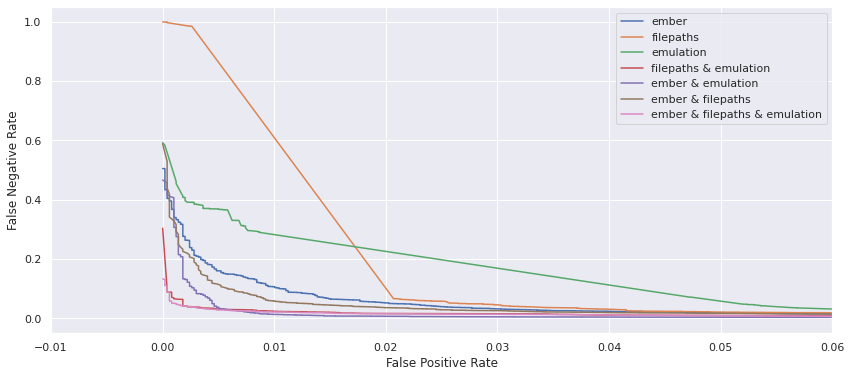

In [6]:
pp = plot_det_curve(models, X_vals, y_val, print_score=False)
_ = plt.xlim([-0.01, 0.06])

[!] Evaluating model: ember...
[!] Evaluating model: filepaths...
[!] Evaluating model: emulation...
[!] Evaluating model: filepaths & emulation...
[!] Evaluating model: ember & emulation...
[!] Evaluating model: ember & filepaths...
[!] Evaluating model: ember & filepaths & emulation...


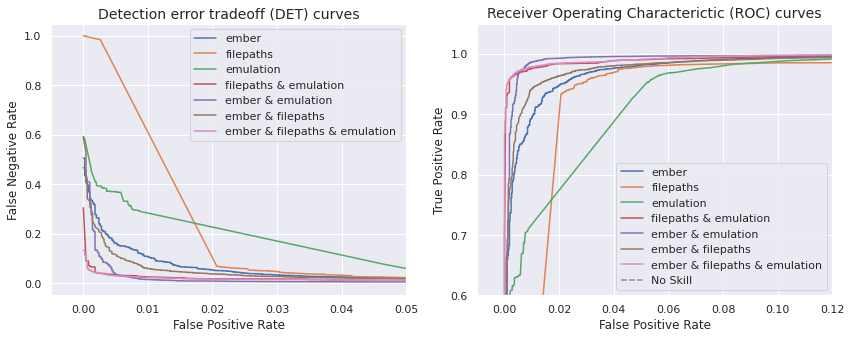

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
probs = evaluate(models, X_vals, y_val, ax=ax[1], print_score=False)
ax[1].set_ylim([0.6, 1.05])
ax[1].set_xlim([-0.01, 0.12])
ax[1].set_title("Receiver Operating Characterictic (ROC) curves", fontsize=14)
#ax[1].legend(legend)

pp = plot_det_curve(models, X_vals, y_val, ax=ax[0], print_score=False)
ax[0].set_xlim([-0.005, 0.05])
ax[0].legend(loc="best")
_ = ax[0].set_title("Detection error tradeoff (DET) curves", fontsize=14)
#_ = ax[0].legend(legend)

## Confusion matrix (incorrect $\%$)

In [8]:
def draw_confusion_matrix(y_true, y_pred, counts=False, figsize=(6,6)):
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)

    f, ax = plt.subplots(1,1, figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")

def print_scores(y_true, y_pred):
    print("F1: ",f1_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Accuracy: ", (y_true == y_pred).mean() * 100)

F1:  0.9871785087384569
Recall:  0.9858993902439024
Precision:  0.9884609506342656
Accuracy:  98.14385150812065


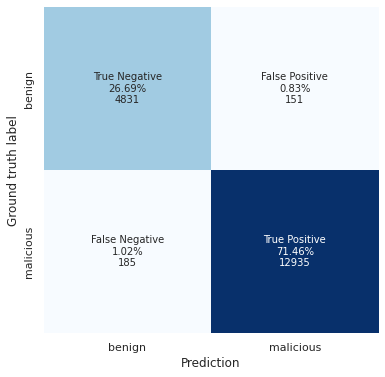

In [9]:
y_pred = (probs_val['ember & filepaths & emulation'] >= 0.8336).astype(int)
draw_confusion_matrix(y_val, y_pred, counts=True)
print_scores(y_val, y_pred)

# Detection rates under fixed false positive rate (FPR)

In [10]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    try:
        thr_index = np.where(thresholds <= threshold)[0][0]
    except IndexError:
        thr_index = 0
    return values[thr_index]

def get_fpr_fnr_dicts(models, Xs, y):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(Xs[model])[:,1]

    fprs, fnrs, tprs, thresholds_roc, thresholds_det = {},{},{},{},{}

    for model in probs:
        fprs[model], tprs[model], thresholds_roc[model] = roc_curve(y, probs[model])
        _, fnrs[model], thresholds_det[model] = det_curve(y, probs[model])
    
    return fprs, fnrs, tprs, thresholds_roc, thresholds_det 

def detection_rates_from_fpr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fpr_rates=list(np.arange(0.0000025, 0.000031, 0.0000025)), savefig=""):
    fixed_fpr_rates = defaultdict(list)
    for fpr_rate in fpr_rates:
        print("===" * 10)
        for model in models:
            threshold = get_threshold_from_rate(thresholds_roc[model], fprs[model], fpr_rate)
            tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
            fnr_rate = get_value_from_threshold(fnrs[model], thresholds_det[model][::-1], threshold)
            fnr_rate = 0
            fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
            print(f"FPR: {fpr_rate*100:>5.3f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

    # keys for y label
    keys = models.keys()

    # rates for x label
    fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
    fpr_rates = [np.round(x*1e5, 2) for x in fpr_rates]

    # rearrange rows, so "all" is last
    tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
    tpr_rates = np.round(tpr_rates*100,2)

    fig, ax = plt.subplots(figsize=(13,7))
    ax = sns.heatmap(tpr_rates, ax = ax,
                annot=True, fmt=".2f",
                xticklabels=[x for x in fpr_rates],
                yticklabels=[x.replace(" & ", " &\n") for x in keys])

    ax.set_xlabel(r"False Positive rate, x in $10^{5}$", fontsize=12)
    ax.set_ylabel("Modules", fontsize=12)
    _ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

    if savefig:
        fig.savefig(f"/data/quo.vadis/img/{savefig}.eps",  format='eps', dpi=600, bbox_inches='tight')

def fpr_from_fnr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fnr_rates=[0.0005, 0.001] + list(np.arange(0.0025, 0.02, 0.0025)), savefig=""):
    fixed_fnr_rates = defaultdict(list)
    for fnr_rate in fnr_rates:
        print("===" * 10)
        for model in models:
            threshold = get_threshold_from_rate(thresholds_det[model], fnrs[model], fnr_rate)
            tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
            fpr_rate = get_value_from_threshold(fprs[model], thresholds_roc[model], threshold)
            fixed_fnr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold])
            print(f"FPR: {fpr_rate*100:>5.2f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")
    # keys for y label
    keys = models.keys()

    # rates for x label
    fnr_rates = [np.array(fixed_fnr_rates[key])[:,2] for key in fixed_fnr_rates][0]
    fnr_rates = [np.round(x*100, 2) for x in fnr_rates]

    # rearrange rows, so "all" is last
    tpr_rates_fn = np.vstack([np.array(fixed_fnr_rates[key])[:,0] for key in fixed_fnr_rates])
    tpr_rates_fn = np.round(tpr_rates_fn*100,2) 

    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(tpr_rates_fn, ax = ax,
                annot=True, fmt=".2f",
                xticklabels=fnr_rates,
                yticklabels=[x.replace(" & ", " &\n") for x in keys],
                cmap="Blues")

    ax.set_xlabel("False Negative rate, %", fontsize=12)
    ax.set_ylabel("Modules", fontsize=12)
    _ = ax.set_title("False Positive rate (%) with fixed False Negative rate", fontsize=14)

    if savefig:
        fig.savefig(f"/data/quo.vadis/img/{savefig}.eps",  format='eps', dpi=600, bbox_inches='tight')


FPR: 0.000% | TPR: 49.48% | FNR:  0.00% | Thr.: 0.9995 | ember
FPR: 0.000% | TPR:  0.07% | FNR:  0.00% | Thr.: 1.0000 | filepaths
FPR: 0.000% | TPR: 41.68% | FNR:  0.00% | Thr.: 1.0000 | emulation
FPR: 0.000% | TPR: 90.26% | FNR:  0.00% | Thr.: 1.0000 | filepaths & emulation
FPR: 0.000% | TPR: 53.78% | FNR:  0.00% | Thr.: 1.0000 | ember & emulation
FPR: 0.000% | TPR: 44.20% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths
FPR: 0.000% | TPR: 86.91% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths & emulation
FPR: 0.025% | TPR: 56.61% | FNR:  0.00% | Thr.: 0.9992 | ember
FPR: 0.025% | TPR:  0.07% | FNR:  0.00% | Thr.: 1.0000 | filepaths
FPR: 0.025% | TPR: 53.76% | FNR:  0.00% | Thr.: 1.0000 | emulation
FPR: 0.025% | TPR: 90.26% | FNR:  0.00% | Thr.: 1.0000 | filepaths & emulation
FPR: 0.025% | TPR: 54.26% | FNR:  0.00% | Thr.: 1.0000 | ember & emulation
FPR: 0.025% | TPR: 47.07% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths
FPR: 0.025% | TPR: 89.07% | FNR:  0.00% | Thr.: 1.0000 | embe

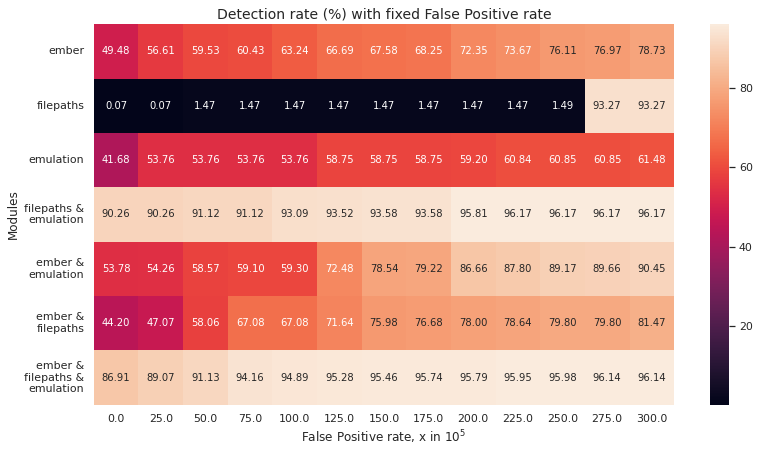

In [11]:
fprs, fnrs, tprs, thresholds_roc, thresholds_det = get_fpr_fnr_dicts(models, X_vals, y_val)
detection_rates_from_fpr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fpr_rates=list(np.arange(2.5e-8, 3.01e-3, 2.5e-4)))

FPR: 37.86% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0018 | ember
FPR: 97.91% | TPR: 99.92% | FNR:  0.05% | Thr.: 0.0000 | filepaths
FPR: 23.63% | TPR: 99.75% | FNR:  0.05% | Thr.: 0.0001 | emulation
FPR: 42.97% | TPR: 99.94% | FNR:  0.05% | Thr.: 0.0000 | filepaths & emulation
FPR: 38.54% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0000 | ember & emulation
FPR: 36.23% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0000 | ember & filepaths
FPR: 21.28% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0000 | ember & filepaths & emulation
FPR: 29.55% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0052 | ember
FPR: 28.22% | TPR: 99.18% | FNR:  0.10% | Thr.: 0.0001 | filepaths
FPR: 23.63% | TPR: 99.75% | FNR:  0.10% | Thr.: 0.0001 | emulation
FPR: 21.22% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0000 | filepaths & emulation
FPR: 25.45% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0001 | ember & emulation
FPR: 29.65% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0000 | ember & filepaths
FPR: 17.70% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0000 | embe

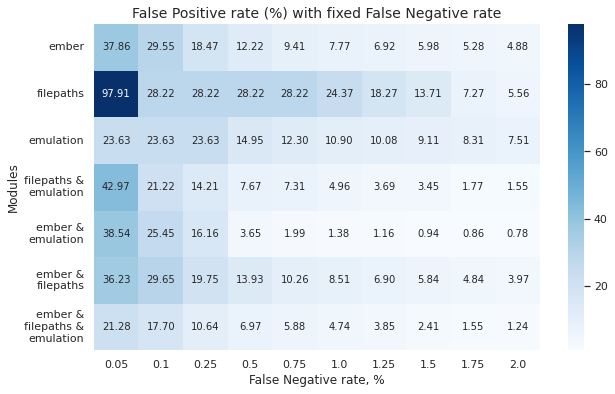

In [12]:
fpr_from_fnr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fnr_rates=[0.0005, 0.001] + list(np.arange(0.0025, 0.02, 0.0025)), savefig="")